# 평가
-성능 평가 지표는 일반적으로 모델이 분류냐 회귀냐에 따라 여러 종류로 나뉜다.
- 회귀의 경우 대부분 실제값과 예측값의 오차 평균값에 기반(뒷 장에서 다시 설명)
- 본 장에서는 분류에 사용되는 평가 지표에 대해 알아볼 것

==> 정확도, 오차행렬정밀도, 재현율, F1 스코어, ROC AUC

## 01 정확도(Accuracy)

- 탑승객이 남자인 경우보다 여자인 경우에 생존 확률이 높았기 때문에 별다른 알고리즘의 적용 없이 무조건 성별이 여자인 경우 생존으로, 남자인 경우 사망으로 예측 결과를 예측해도 이와 비슷한 수치가 나올 수 있다. 단지 성별 조건 하나만을 가지고 결정하는 별거 아닌 알고리즘도 높은 정확도를 나타내는 상황이 발생
- 사이킷런의 BaseEstimator 클래스를 상속받아 아무런 학습을 하지 않고, 성별에 따라 생존자를 예측하는 단순한 Classifier를 생성. 사이킷런은 BaseEstimator를 상속받으면
Customized 형태의 Estimator를 개발자가 생성할 수 있음

In [113]:
import numpy as np

In [114]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  # fit() 메서드는 아무것도 학습하지 않음
  def fit(self, X, y=None):
    pass
  # predict() 메서드는 단순히 sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
  def predict(self, X):
    pred = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i] == 1:
        pred[i] = 0
      else:
        pred[i] = 1
    return pred

- 생성된 MyDummyClassifier를 이용해 앞 장의 타이타닉 생존자 예측을 수행

In [115]:
### 저번 과제에 나온 transform_features 함수 밑에 코드에서 필요 ###

from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df
# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
  return df
# 레이블 인코딩 수행.
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df
# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df) :
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


<ipython-input-115-a26cc77be5af>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)
<ipython-input-115-a26cc77be5af>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

- 교훈-> 이렇게 단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도 결과는 약 78.77%로 꽤 높은 수치가 나올 수 있기에 정확도를 평가 지표로 사용할 때는 매우 신중
- 특히 정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님. 100개의 데이터가 있고 이 중에 90개의 데이터 레이블이 0, 단 10개의 데이터 레이블
이 1이라고 한다면 무조건 0으로 예측 결과를 반환하는 ML 모델의 경우라도 정확도가 90%가 됨 (아래의 MNIST 데이터 세트 예시 참고)

- 원래 MNIST 데이터 세트는 레이블 값이 0부터 9까지 있는 멀티 레이블 분류
이것을 레이블 값이 7인 것만 True, 나머지 값은 모두 False로 변환해 이진 분류 문제로 바꿈
즉, 전체 데이터의 10%만 True, 나머지 90%는 False인 불균형한 데이터 세트로 변형


In [117]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass

  # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [118]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 텍스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 텍스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
Name: count, dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


- 단지 모든 것을 0으로만 예측해도 MyFakeClassifier의 정확도가 90%로 유수의 ML 알고리즘과 어깨를 겨룰 수 있다는 것은 말도 안 되는 결과
- 이러한 한계점을 극복하기 위해 여러 분류 지표와 함께 적용하여 ML 모델 성능을 평가해야 함

## 02 오차 행렬

- TN는 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0
- FP는 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative 값 0
- FN은 예측값을 Negative값 0으로 예측했는데 실제 값은 Positive 값 1
- TP는 예측값을 Positive값 1로 예측했는데 실제 값 역시 Positive 값 1


In [119]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

- 정확도를 오차 행렬 상에서 정의하면,
- 예측 결과와 실제 값이 동일한 건수/전체 데이터 수 = (TN + TP)/(TN + FP + FN + TP)

## 03 정밀도와 재현율

- 정밀도 = TP / (FP + TP) -> 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
- 재현율 = TP / (FN + TP) -> 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율 , 민감도라고도 부름

##### 정밀도 계산, 재현율 계산, get_clf_eval()함수 만들기

In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도:{0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

- LogisticRegression 객체의 생성 인자로 입력되는 solver—iblinear'는 로지스틱 회귀의 최적화 알고리즘 유형을 지정. 보통 작은 데이터 세트의 이진 분류인 경우 solver는 liblinear가 약간 성능이 좋은 경향이 있다. solver의 기본값은 Ibfgs이며 데이터 세트
가 상대적으로 크고 다중 분류인 경우 적합

In [121]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할
titanic_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

<ipython-input-115-a26cc77be5af>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)
<ipython-input-115-a26cc77be5af>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

오차 행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도: 0.8246, 재현율: 0.7705


### 정밀도/재현율 트레이드오프
- 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있음.
- 하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한 쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움. 이를 정밀도/재현율의 트레이드오프(Trade-off)라 함

- 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블(Label, 결정 클래스 값)에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구하고, 예측확률이 큰 레이블값으로 예측하게 됨
- 이진 분류에서 predict_proba()를 수행해 반환되는 ndarray는 첫 번째 칼럼이 클래스 값 0에 대한 예측 확률, 두 번째 칼럼이 클래스 값 1에 대한 예측 확률

In [122]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 shape:{0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합해 예측확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 shape:(179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


In [123]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


##### 바로 앞 예제의 LogisticRegression 객체의 predict_proba() 메서드로 구한 각 클래스별 예측 확률값인 pred_proba 객체 변수에 분류 결정 임곗값(threshold)을 0.5로 지정한 Binarizer 클래스를 적용해 최종 예측값 구하기

In [124]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값, 분류 결정 임곗값임
custom_threshold = 0.5

# predict_proba() 반환값의 두번째 칼럼, 즉 positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [125]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤.
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도:0.8212, 정밀도: 0.7042, 재현율: 0.8197


- 임곗값을 낮추니 재현율이 오르고  정밀도가 떨어짐
- *WHY?* 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 됨. 확률이 0.5가 아닌 0.4부터 Positive로 예측을 너그럽게 하기 때문에 True값이 많아지게 됨

In [126]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  # threshold list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도:0.8212, 정밀도: 0.7042, 재현율: 0.8197
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도:0.8547, 정밀도: 0.7869, 재현율: 0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도: 0.8246, 재현율: 0.7705
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도:0.8715, 정밀도: 0.8654, 재현율: 0.7377
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도:0.8771, 정밀도: 0.8980, 재현율: 0.7213


##### 사이킷런은 이와 유사한 **precision_recall_curve()** 제공- 타이타닉 예측 모델의 임곗값별 정밀도와 재현율 구하기



In [127]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측확률을 precision_recall_curve로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape:', thresholds.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임곗값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3))

반환된 분류 결정 임계값 배열의 shape: (165,)
샘플 추출을 위한 임곗값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값: [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도: [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율: [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


##### precision_recall_curve() API를 이용해 정밀도와 재현율 곡선을 시각화

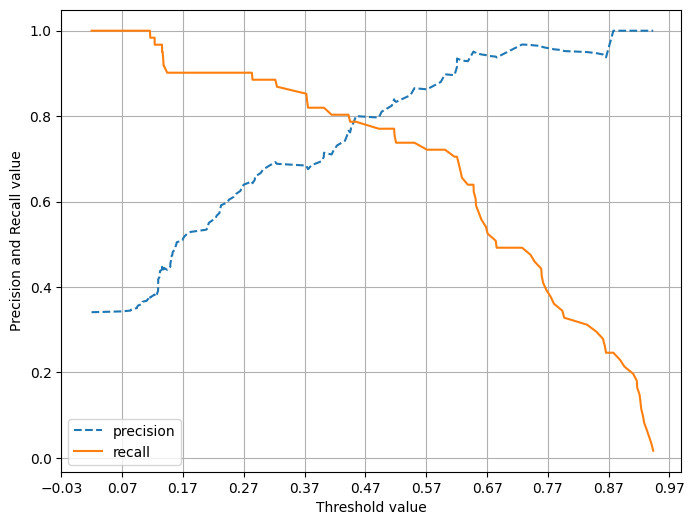

In [128]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X축의 Scale을 0.1단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # X축, Y축 label과 legend, 그리고 grid설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show

precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

- 임곗값이 낮을수록 많은 수의 양성 예측으로 인해 정밀도 값이 극도로 낮아지고 재현율 값이 극도로 낮아진다.

## 04 F1 스코어

- F1 스코어는 정밀도와 재현율을 결합한 지표
- 둘 중 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐

In [129]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7966


##### 타이타닉 생존자 예측에서 임곗값을 변화시키면서 F1 스코어를 포함한 평가 지표 구하기 -> 앞에서 작성한 get_clf_eval() 함수에 추가

In [130]:
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  # F1 스코어 추가
  f1 = f1_score(y_test, pred)
  print('오차행렬')
  print(confusion)
  # f1 score print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율 : {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

threshold = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.01974987688169401
오차행렬
[[  1 117]
 [  0  61]]
정확도: 0.3464, 정밀도: 0.3427, 재현율 : 1.0000, F1:0.5105
임곗값: 0.06956413942117096
오차행렬
[[  2 116]
 [  0  61]]
정확도: 0.3520, 정밀도: 0.3446, 재현율 : 1.0000, F1:0.5126
임곗값: 0.08402808434419032
오차행렬
[[  3 115]
 [  0  61]]
정확도: 0.3575, 정밀도: 0.3466, 재현율 : 1.0000, F1:0.5148
임곗값: 0.08474206808095705
오차행렬
[[  4 114]
 [  0  61]]
정확도: 0.3631, 정밀도: 0.3486, 재현율 : 1.0000, F1:0.5169
임곗값: 0.08920160567073845
오차행렬
[[  5 113]
 [  0  61]]
정확도: 0.3687, 정밀도: 0.3506, 재현율 : 1.0000, F1:0.5191
임곗값: 0.09445723674913087
오차행렬
[[  6 112]
 [  0  61]]
정확도: 0.3743, 정밀도: 0.3526, 재현율 : 1.0000, F1:0.5214
임곗값: 0.09465144034631827
오차행렬
[[  7 111]
 [  0  61]]
정확도: 0.3799, 정밀도: 0.3547, 재현율 : 1.0000, F1:0.5236
임곗값: 0.09530728423857057
오차행렬
[[  8 110]
 [  0  61]]
정확도: 0.3855, 정밀도: 0.3567, 재현율 : 1.0000, F1:0.5259
임곗값: 0.0966386969995903
오차행렬
[[  9 109]
 [  0  61]]
정확도: 0.3911, 정밀도: 0.3588, 재현율 : 1.0000, F1:0.5281
임곗값: 0.10082951040514267
오차행렬
[[ 10 108]
 [  0  61]]
정확도: 0.3966, 정밀도: 0.3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- F1 스코어는 임곗값이 0.6일 때 가장 좋은 값을 보여줌

## 05 ROC 곡선과 AUC

- ROC 곡선은 FPR(False Positive Rate) 이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선

- TPR은 실제 양성 중 정확히 예측된 것 (재현율, 민감도)
- TNR은 실제 음성 중 정확히 예측된 것 (특이성)
- 따라서, FPR = 1- TNR



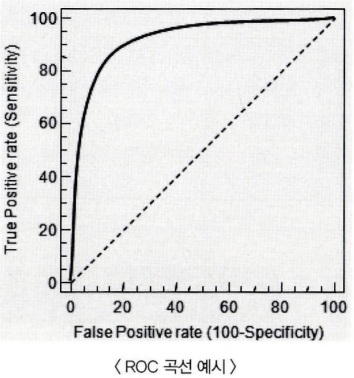



- 가운데 직선은 ROC 직선의 최저 값 (동전을 무작위로 던져 앞/뒤를 맞추는 랜덤 수준, AUC=0.5)
- ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것이며, 멀어질수록 성능이 뛰어남


---


- FPR을 0에서 1까지 변경하는 것은 분류 결정 임곗값을 변경하면 됨
- FPR을 0으로 만들려면 임곗값을 1로 만들기
- FPR을 1로 만들려면 임곗값을 0으로 만들기(TN을 0으로 만들려고)

In [131]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 step으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0],5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


##### FPR의 변화에 따른 TPR의 변화를 ROC 곡선으로 시각화

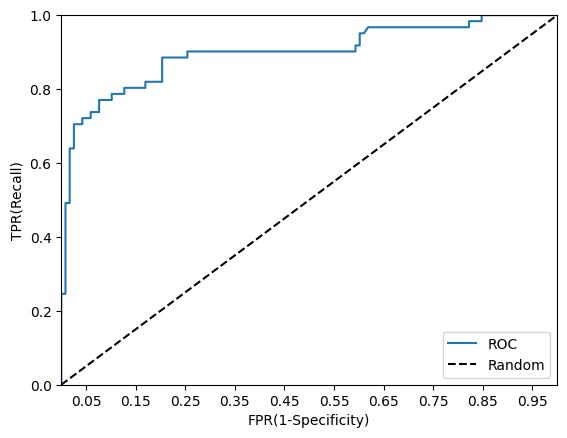

In [132]:
def roc_curve_plot(y_test, pred_proba_c1):
  # 임곗값에 따른 FPR, TPR 값을 반환받음
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  # ROC 곡선을 그래프 곡선으로 그림
  plt.plot(fprs, tprs, label='ROC')
  # 가운데 대각선 직선 그림
  plt.plot([0,1],[0,1], 'k--', label='Random')

  # FPR x축의 Scale을 0.1단위로 변경, X,Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end, 0.1),2))
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.xlabel('FPR(1-Specificity)')
  plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

##### AUC(Area Under Curve) 값은 ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치
- AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐 (가운데 대각선 직선은 랜덤 수준의 이진분류 AUC값으로 0.5)  
🤔AUC가 큰 걸 찾는건 음성을 잘 맞추면서도 양성을 잘 맞추는 걸 찾는 건가

In [133]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8987


In [148]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test , pred)
  precision = precision_score(y_test , pred)
  recall = recall_score(y_test , pred)
  f1 = f1_score(y_test,pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},F1 ： {3:.4f}, AUC：{4:.4f}'.format(accuracy, precision, recall,f1, roc_auc))


## 피마 인디언 당뇨병 예측

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pit
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [136]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- Null값 없음, 별도의 피처 인코딩 필요없음

##### 로지스틱 회귀 이용해서 예측모델 생성

In [137]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측, 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741,F1 ： 0.6392, AUC：0.7919


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


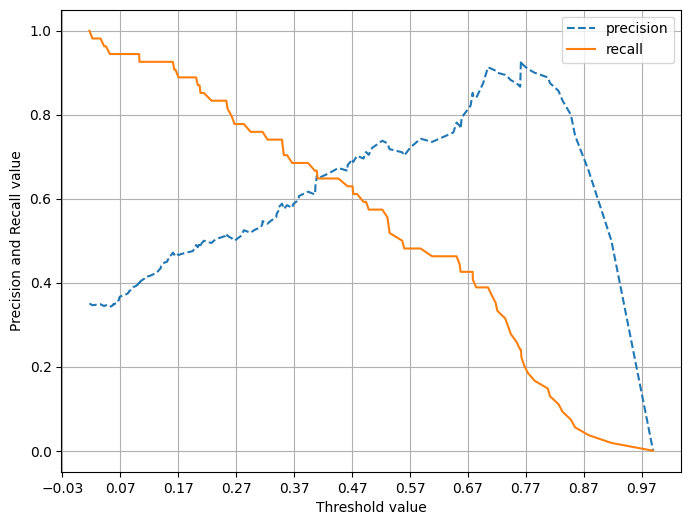

In [138]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

- 재현율 곡선을 보면 임곗값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것임
- 임곗값을 인위적으로 조작

In [139]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- min값이 0인 게 상당히 많음

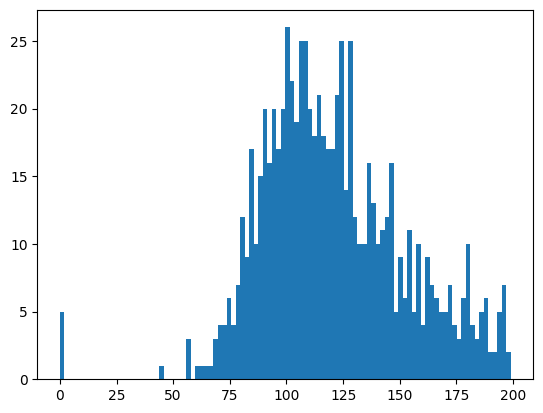

In [140]:
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show()

In [141]:
# 0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0 인 데이터 건수를 추출하고 퍼센트 계산
for feature in zero_features:
  zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
  print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


- SkinThickness와 Insulin의 0값은 각각 비율이 높음.
- 이들 데이터를 일괄 삭제하기보다 0값을 평균값으롣 대체

In [142]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

- 로지스틱 회귀의 경우, 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋음

In [143]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측, 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba =lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,F1 ： 0.6804, AUC：0.8433


In [152]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test , pred)
  precision = precision_score(y_test , pred)
  recall = recall_score(y_test , pred)
  f1 = f1_score(y_test,pred)
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},F1 ： {3:.4f}, AUC: {4:.4F}'.format(accuracy, precision, recall,f1,roc_auc))

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  # threshold list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict, pred_proba_c1)

In [153]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963,F1 ： 0.6615, AUC: 0.8433
임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,F1 ： 0.6774, AUC: 0.8433
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,F1 ： 0.6667, AUC: 0.8433
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,F1 ： 0.6667, AUC: 0.8433
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,F1 ： 0.6792, AUC: 0.8433
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,F1 ： 0.6857, AUC: 0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,F1 ： 0.6931, AUC: 0.8433
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,F1 ： 0.6804, AUC: 0.8433


- 임곗값 0.48이 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 좋은 임곗값으로 보임

In [154]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)
# 위에서 구한 lr_clf의 predict_proba()의 예측확률 array에서 1에 해당하는 칼럼 값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,F1 ： 0.6931, AUC: 0.8433


###🧙🏻‍♀️정리
- 분류에 사용되는 성능 평가 지표: 정확도,오차행렬, 정밀도, 재현율, F1스코어, ROC-AUC
- 이진분류의 레이블 값이 불균형하게 분포될 경우 정확도만으로는 모델 예측성능 평가 불가
- 오차행렬은 Negative와 Positive 값을 가지는 실제 클래스 값과 예측 클래스 값이 True와 False에 따라 TN, FP, FN, TP로 매핑되는 4분면 행렬을 기반으로 예측 성능을 평가
- 특히 재현율이 상대적으로 더 중요한 지표인 경우는 암 양성 예측 모델과 같이 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
- 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높이는 방법에 대해 배움
- F1 스코어는 정밀도와 재현율을 결합한 평가 지표이며, 정밀도와 재현율이 어느 한 쪽으로 치우치지 않을 때 높은 지표값
- AUC(Area Under Curve) 값은 ROC 곡선 밑의 면적을 구한 것으로서 일
반적으로 1에 가까울수록 좋은 수치